In [8]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()

2024-07-09 23:05:47,981 INFO: generated new fontManager


True

In [2]:
project_name = "naveen"
api_key = os.getenv("HOPSWORKS_API_KEY")

connection = hopsworks.login(project=project_name, api_key_value=api_key)
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/865430
2024-07-09 22:57:47,288 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-07-09 22:57:47,290 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try: 
    feature_view = fs.get_feature_view(name="iris", version=1)
except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/865430/fs/861253/fv/iris/version/1


In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 
2024-07-09 23:00:22,377 WARNING: VersionWarning: Incremented version to `1`.



In [5]:
y_train

,variety
1,Versicolor
2,Virginica
4,Setosa
7,Versicolor
8,Setosa
...,...
144,Versicolor
145,Virginica
146,Virginica
147,Virginica


In [9]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [10]:
y_pred = model.predict(X_test)
y_pred

array(['Setosa', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa',
       'Virginica', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor',
       'Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Virginica',
       'Versicolor', 'Virginica', 'Setosa', 'Virginica', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Virginica'], dtype=object)

In [20]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         9
  Versicolor       0.90      1.00      0.95         9
   Virginica       1.00      0.92      0.96        12

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [13]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[ 9  0  0]
 [ 0  9  0]
 [ 0  1 11]]


2024-07-09 23:10:28,706 WARNING: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



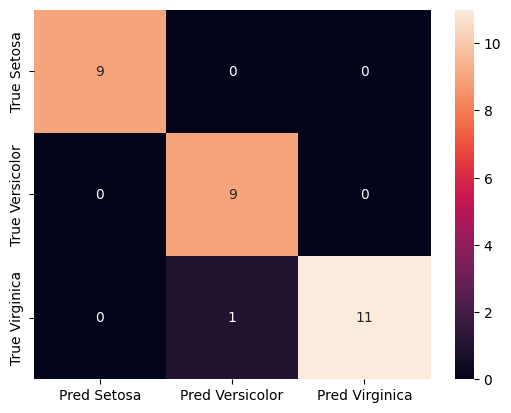

In [15]:
from matplotlib import pyplot

df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("assets/confusion_matrix.png") 
fig.show()

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import shutil

mr = connection.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/iris_model.pkl")
shutil.copyfile("assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="iris", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Iris Flower Predictor")

iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/18007 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/11814 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/509 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/865430/models/iris/1


Model(name: 'iris', version: 1)